In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
data_train = pd.read_csv(r"C:\Users\91628\Downloads\train (7).csv")

In [16]:
data_train

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
0,7,1820,1,240,1026,1133,2,8,1925,1950,184000
1,7,1646,1,240,918,918,2,7,1941,1950,164000
2,5,1316,2,484,926,926,1,6,1929,2001,130000
3,10,2402,3,672,3094,2402,2,10,2008,2008,555000
4,7,1253,2,402,1237,1253,2,6,1995,1996,176000
...,...,...,...,...,...,...,...,...,...,...,...
1163,6,1400,2,440,672,672,1,6,1978,1978,149500
1164,7,1472,2,402,384,802,2,7,1991,1992,160000
1165,5,789,1,250,789,789,1,5,1948,1950,115000
1166,6,1661,1,377,992,1661,1,8,1955,1996,165500


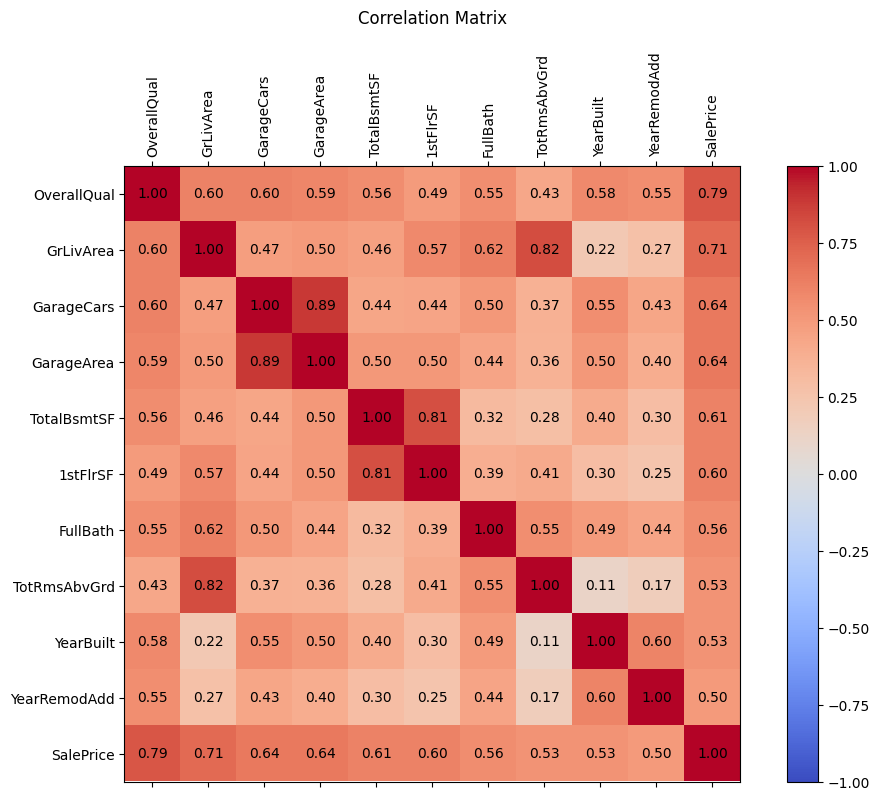

In [17]:
# Calculating the correlation matrix
corr = data_train.corr()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the correlation matrix as a heatmap
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add a colorbar
fig.colorbar(cax)

# Add annotations (correlation values)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')

# Set x and y labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# Add title
plt.title('Correlation Matrix', pad=20)

# Display the plot
plt.show()

In [18]:
# Feature Engineering
data_train['TotalArea'] = data_train['GrLivArea'] + data_train['TotalBsmtSF']           #Adding new columns after modifying the old ones
data_train['AgeOfHouse'] = 2023 - data_train['YearBuilt']
data_train['RemodelAge'] = 2023 - data_train['YearRemodAdd']

In [19]:
# Select features (X) and target variable (Y)
X = X = data_train.iloc[:,1:].values
y = data_train.OverallQual

In [20]:
y

0        7
1        7
2        5
3       10
4        7
        ..
1163     6
1164     7
1165     5
1166     6
1167     7
Name: OverallQual, Length: 1168, dtype: int64

In [21]:
X

array([[1820,    1,  240, ..., 2846,   98,   73],
       [1646,    1,  240, ..., 2564,   82,   73],
       [1316,    2,  484, ..., 2242,   94,   22],
       ...,
       [ 789,    1,  250, ..., 1578,   75,   73],
       [1661,    1,  377, ..., 2653,   68,   27],
       [1442,    2,  500, ..., 2866,   33,   33]], shape=(1168, 13))

In [55]:
# Standardization (Feature Scaling) with Batch Normalization
def batch_normalize(X):
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_normalized = (X - X_mean) / (X_std + 1e-8)
    return X_normalized

# Apply batch normalization to the features
X_normalized = batch_normalize(X)

# Add a column of ones to X to account for the intercept term
X_normalized = np.c_[np.ones(X_normalized.shape[0]), X_normalized]

# Convert to numpy arrays
X_normalized = np.array(X_normalized)
y = np.array(y)

In [61]:
# Batch Normalization Function
def batch_normalize(batch):
    mean = np.mean(batch, axis=0)
    std = np.std(batch, axis=0) + 1e-8  # Avoid division by zero
    return (batch - mean) / std

# R-squared Function
def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

# Linear Regression Model with L2 Regularization
def linear_regression_with_batch_norm(X, y, alpha, learning_rate, 
                                      iterations, batch_size):
    m, n = X.shape
    theta = np.zeros(n + 1)  # Including intercept term
    X = np.c_[np.ones(m), X]  # Add intercept
    cost_history = []
    r2_scores = []
    thetas = []

    count = 0
    while count < m:
        # Create batch
        X_batch = X[count:count + batch_size]
        y_batch = y[count:count + batch_size]

        # Apply Batch Normalization
        X_batch[:, 1:] = batch_normalize(X_batch[:, 1:])

        # Gradient Descent on Batch
        for _ in range(iterations):
            predictions = X_batch.dot(theta)
            errors = predictions - y_batch
            gradient = (1 / batch_size) * (X_batch.T.dot(errors) + alpha * np.r_[0, theta[1:]])
            theta -= learning_rate * gradient

            # Cost function
            cost = (1 / (2 * batch_size)) * (np.sum(errors ** 2) + alpha * np.sum(theta[1:] ** 2))
            cost_history.append(cost)

        # Calculate R² for the batch
        batch_r2 = r_squared(y_batch, X_batch.dot(theta))
        r2_scores.append(batch_r2)
        maxr2index = 0
        maximumr2score = max(r2_scores)
        for i in range(len(r2_scores)):
            if r2_scores[i] == maximumr2score:
                maxr2index = i

        
        count += batch_size

    return thetas.append(theta), cost_history, r2_scores

# Hyperparameters
alpha = 0.1
learning_rate = 0.01
iterations = 1000
batch_size = 50

# Train the Model
theta, cost_history, r2_scores = linear_regression_with_batch_norm(X, y, alpha, learning_rate, iterations, batch_size)



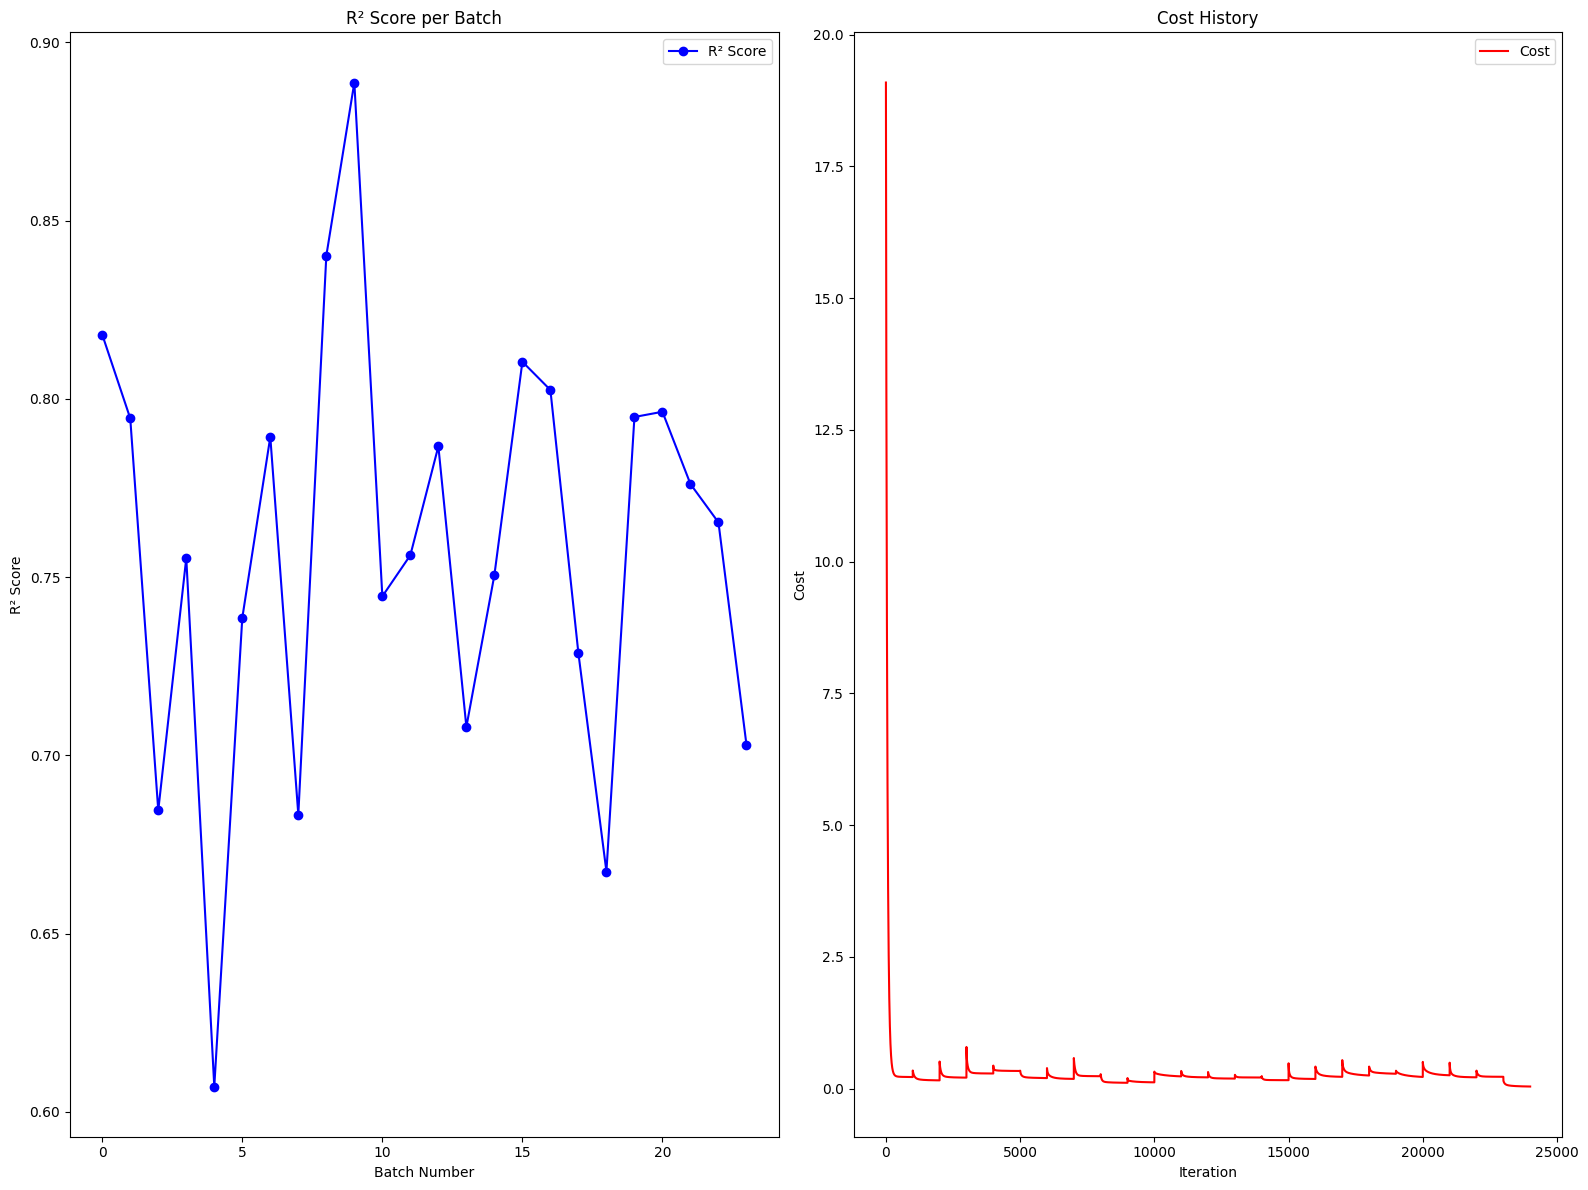

In [62]:
# Plotting the results
plt.figure(figsize=(16, 12))

# Plot R2 score per batch on the LEFT
plt.subplot(1, 2, 1)
plt.plot(range(len(r2_scores)), r2_scores, marker='o', color='blue', label='R² Score')
plt.xlabel('Batch Number')
plt.ylabel('R² Score')
plt.title('R² Score per Batch')
plt.legend()

# Plot cost history on the RIGHT
plt.subplot(1, 2, 2)
plt.plot(range(len(cost_history)), cost_history, color='red', label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
r2_scores

[np.float64(0.818003738038275),
 np.float64(0.7945082802405833),
 np.float64(0.6845308311452144),
 np.float64(0.7553066175517733),
 np.float64(0.6070974817597397),
 np.float64(0.7385432162427925),
 np.float64(0.7893168711959617),
 np.float64(0.6833541154482496),
 np.float64(0.8401279834683115),
 np.float64(0.8887024386317587),
 np.float64(0.7445885067614222),
 np.float64(0.756125819406581),
 np.float64(0.786662629635948),
 np.float64(0.7079542161750054),
 np.float64(0.7505378843376765),
 np.float64(0.8103899294759975),
 np.float64(0.8024669117184534),
 np.float64(0.728588694591277),
 np.float64(0.6674071106990223),
 np.float64(0.7948941957975331),
 np.float64(0.7963554395230286),
 np.float64(0.7760882648476614),
 np.float64(0.7653158825591148),
 np.float64(0.7029317593962943)]